In [1]:
import re, requests, string, folium
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn import preprocessing
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# COVID-19 and the public health care around the world
## Cities Dataset Pre-processing

First, we need to read the cities dataset from the [Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_cities).

In [2]:
wiki_cities = 'https://en.wikipedia.org/wiki/List_of_largest_cities'
cities_rq = requests.get(wiki_cities)

The following snippet pre-process the dataframe, forces the `int` type for numeric columns and removes invalid values.

In [3]:
soup_cities = BeautifulSoup(cities_rq.text, 'html.parser')
table_cities = soup_cities.find_all('table')[1]
cities = pd.read_html(str(table_cities))[0]

# Removes columns multindex, renames and capitalizes the labels
cities.columns = cities.columns.map(' '.join).str.strip(' ')
cities.columns = map(lambda x: string.capwords(x), cities.columns)
cities.rename(columns={'City City': 'City', 'Country Country': 'Country', 'Skyline Skyline': 'Skyline','City Proper Definition': 'City Definition', 'City Proper Population': 'City Population', 'City Proper Area(km2)': 'City Area(km2)','Urban Area[9] Population': 'Urban Population','Urban Area[9] Area(km2)': 'Urban Area(km2)', 'Metropolitan Area Area(km2)': 'Metropolitan Area(km2)', 'Metropolitan Area Population': 'Metropolitan Population'}, inplace = True)

# Removes invalid characters from the columns
for col in ['City Population','City Area(km2)', 'Metropolitan Population','Metropolitan Area(km2)', 'Urban Area(km2)']: 
    cities[col] = cities[col].str.replace(r'\[[0-9A-Za-z]+\]', '')
    
# Process invalid values
cities['Metropolitan Population'].fillna(cities['City Population'], inplace=True)
cities['Metropolitan Area(km2)'].fillna(cities['City Area(km2)'], inplace=True)
cities.dropna(subset=['City Population'], inplace=True)
cities.drop(columns=['Skyline'], inplace=True)

# Forces int type for numeric columns
for col in ['City Population', 'City Area(km2)', 'Metropolitan Population', 'Metropolitan Area(km2)', 'Urban Area(km2)']:
    cities[col] = cities[col].str.replace(',', '').astype(int)
    
cities = cities.sort_values(by='City Population', ascending=False).reset_index(drop=True)
cities['Demographic Density'] = cities['City Population'] / cities['City Area(km2)']

In [4]:
cities

,City,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density
0,Chongqing,China,Municipality,30752000,82403,30752000,82403,8300000,1489,373.190296
1,Shanghai,China,Municipality,24183000,6341,24183000,6341,22125000,4015,3813.751774
2,Beijing,China,Municipality,21707000,16411,21707000,16411,19430000,4144,1322.710377
3,Delhi,India,National capital territory,16753235,1484,29000000,3483,28125000,2240,11289.241914
4,Chengdu,China,City (sub-provincial),16044700,14378,16044700,14378,12160000,1813,1115.920156
...,...,...,...,...,...,...,...,...,...,...
71,San Francisco,United States,Consolidated city-county,883305,122,4729484,6417,6100000,2865,7240.204918
72,"Washington, D.C.",United States,Federal district,702455,177,6263245,17009,7515000,5281,3968.672316
73,Boston,United States,City,694583,125,4875390,9033,7130000,9189,5556.664000
74,Düsseldorf,Germany,Urban district,642304,217,1555985,217,6660000,2655,2959.926267


In [5]:
cities.dtypes

City                        object
Country                     object
City Definition             object
City Population              int64
City Area(km2)               int64
Metropolitan Population      int64
Metropolitan Area(km2)       int64
Urban Population             int64
Urban Area(km2)              int64
Demographic Density        float64
dtype: object

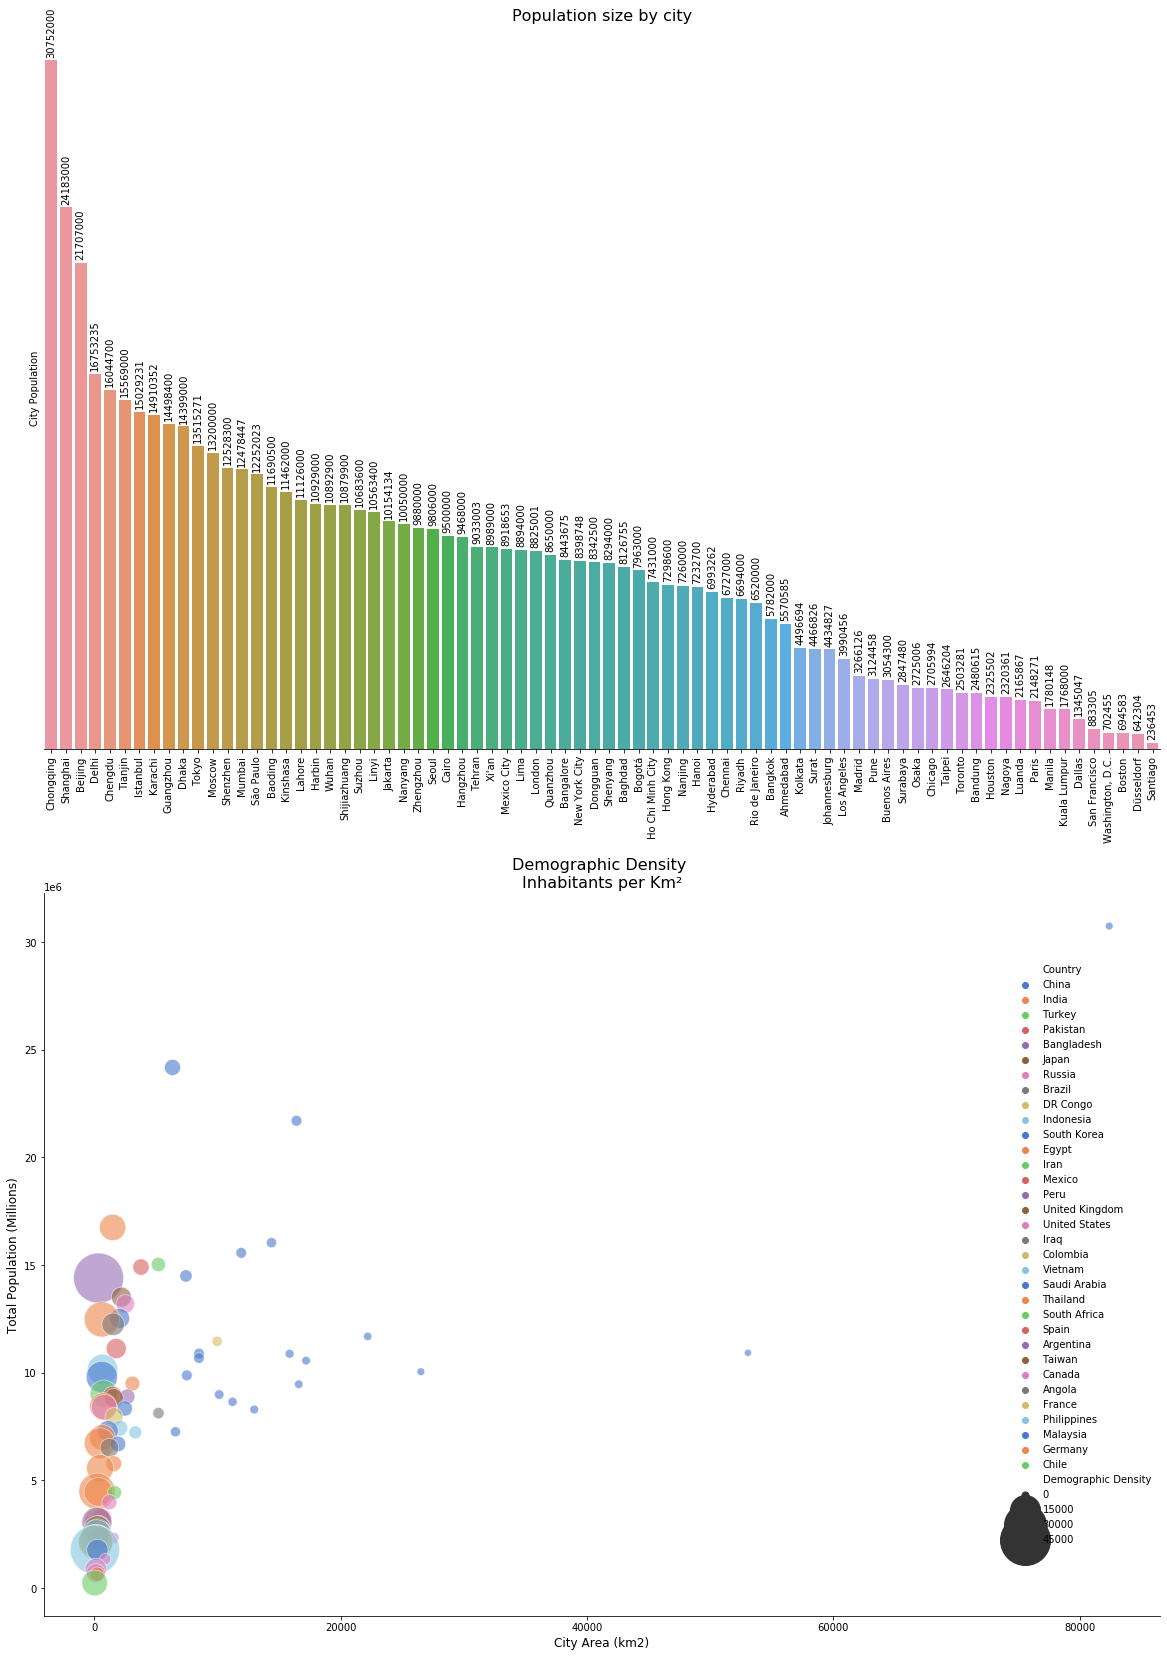

In [6]:
fig, ax = plt.subplots(figsize=(20, 16))
plt.subplots_adjust(bottom=-0.5)

s1 = plt.subplot(211)
bar = sns.barplot(cities['City'], cities['City Population'])
plt.xticks(rotation=90)
plt.yticks([])
plt.xlabel(None)
plt.xticks(fontsize=10)
plt.title('Population size by city', fontsize=16)
[s1.spines[side].set_visible(False) for side in ['left','right','top']]
[bar.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+150000),ha='center', va='bottom', c='black', fontsize=10, rotation=90) for p in bar.patches]

s2 = plt.subplot(212)
sns.scatterplot(x='City Area(km2)', y='City Population', hue='Country',
                data=cities, size='Demographic Density', sizes=(50,2500), alpha=.6, palette="muted")
plt.ticklabel_format(scilimits=(6,6), axis='y')
plt.ylabel('Total Population (Millions)', fontsize=12)
plt.xlabel('City Area (km2)', fontsize=12)
plt.title('Demographic Density \nInhabitants per Km²', fontsize=16)
plt.legend(loc='center right', frameon=False).get_frame().set_facecolor('none')
[s2.spines[side].set_visible(False) for side in ['right','top']]
plt.show();

### Biggest cities per country

In [7]:
countries = cities[['City', 'Country', 'City Population','City Area(km2)','Demographic Density']].groupby('Country').sum().sort_values(by='City Population', ascending=False)
countries['Cities'] = cities[['City', 'Country']].groupby('Country').count()
countries.sort_values(by='Cities', ascending=False, inplace=True)
countries.head(10)

,City Population,City Area(km2),Demographic Density,Cities
Country,,,,
China,279153800,361313,36229.290805,22
India,69054182,5144,129363.584075,9
United States,21046090,5448,38354.642105,8
Japan,18560638,2742,25397.349493,3
Indonesia,15482229,1183,38170.414591,3
Pakistan,26036352,5552,10223.318605,2
Brazil,18772023,2742,13395.127286,2
Vietnam,14663700,5386,5780.779416,2
Canada,2503281,630,3973.461905,1


In [8]:
biggest_cities = cities.groupby('Country').max().sort_values('City Population', ascending=False)
biggest_cities.head(10)

,City,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density
Country,,,,,,,,,
China,Zhengzhou,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725
India,Surat,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683
Turkey,Istanbul,Metropolitan municipality,15029231,5196,15029231,5196,13860000,1360,2892.461701
Pakistan,Lahore,Metropolitan city,14910352,3780,14910352,3780,16900000,1036,6278.781038
Bangladesh,Dhaka,Capital city,14399000,338,14543124,338,18595000,453,42600.591716
Japan,Tokyo,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778
Russia,Moscow,Federal city,13200000,2511,13200000,2511,16555000,5698,5256.869773
Brazil,São Paulo,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946
DR Congo,Kinshasa,City-province,11462000,9965,11462000,9965,12960000,583,1150.225790


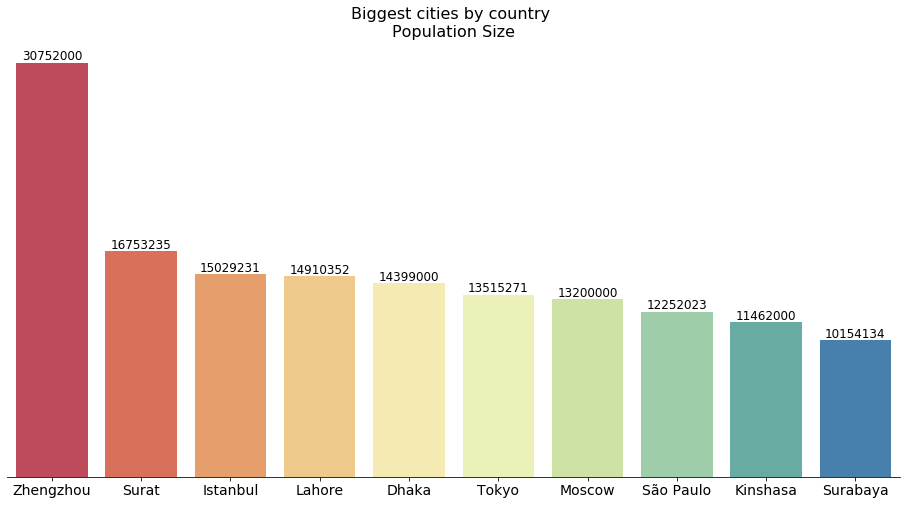

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
bar = sns.barplot(x='City', y='City Population', data=biggest_cities.head(10), palette='Spectral')

[bar.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+0.2),ha='center', va='bottom', c='black', fontsize=12) for p in bar.patches]

plt.yticks([])
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(fontsize=14)
plt.title('Biggest cities by country \nPopulation Size', fontsize=16)
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
plt.show();

## Selected Cities

In [10]:
selected_cities = biggest_cities.loc[['China','India','Brazil','Japan','United States']]
selected_cities.reset_index(drop=False, inplace=True)
selected_cities.set_index('City', inplace=True)
selected_cities

,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density
City,,,,,,,,,
Zhengzhou,China,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725
Surat,India,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683
São Paulo,Brazil,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946
Tokyo,Japan,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778
"Washington, D.C.",United States,Federal district,8398748,1553,19303808,22463,21045000,11875,10685.430025


In [11]:
selected_cities['Latitude'], selected_cities['Longitude'] = [0,0]
geolocator = Nominatim(user_agent="covid-19")
for city, country in zip(selected_cities.index, selected_cities['Country']):
    try:
        location = geolocator.geocode('{}, {}'.format(city,country), timeout=10000)
        print(location.latitude, location.longitude)
        selected_cities.loc[city,'Latitude'] = location.latitude
        selected_cities.loc[city,'Longitude'] = location.longitude
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(c, e.message))


34.7591877 113.6524076
21.1864607 72.8081281
-23.5506507 -46.6333824
35.6828387 139.7594549
38.8948932 -77.0365529


In [12]:
selected_cities

,Country,City Definition,City Population,City Area(km2),Metropolitan Population,Metropolitan Area(km2),Urban Population,Urban Area(km2),Demographic Density,Latitude,Longitude
City,,,,,,,,,,,
Zhengzhou,China,Special administrative region,30752000,82403,30752000,82403,22125000,4144,6611.050725,34.759188,113.652408
Surat,India,National capital territory,16753235,1484,29000000,7256,28125000,2240,21935.092683,21.186461,72.808128
São Paulo,Brazil,Municipality,12252023,1521,21734682,7947,20935000,3043,8055.241946,-23.550651,-46.633382
Tokyo,Japan,Metropolis prefecture,13515271,2191,37274000,13452,38505000,8223,12111.137778,35.682839,139.759455
"Washington, D.C.",United States,Federal district,8398748,1553,19303808,22463,21045000,11875,10685.430025,38.894893,-77.036553


In [116]:
def build_map(city):
    city = city
    lat = selected_cities.loc[city, 'Latitude']
    lng = selected_cities.loc[city, 'Longitude']
    map = folium.Map(width=800, height=600,location=[lat, lng], zoom_start=12)
    folium.Marker(location=[lat, lng], tooltip=city, icon=folium.Icon(color='black', icon='bank', prefix='fa')).add_to(map)
    venues = explore(lat, lng)
    selected_cities.loc[city, 'Hospitals'] = len(venues)
    for v in venues:
        folium.Marker(location=[v['lat'], v['lng']], tooltip=v['name'], icon=folium.Icon(color='red', icon='hospital-o', prefix='fa')).add_to(map)
    return map

def explore(latitude, longitude):
    venues = []
    CLIENT_ID = 'OMVPO1DVXFDX4RZ1L1VCKMC45ZML0TK3JQP0JBIK4YAQAHFB'
    CLIENT_SECRET = '2HVRKXEVMZ5CEHUFXY5G3PFEHS4TQYQUBXXU51WZIS4R1PXF'
    VERSION = '20180604'
    category = '4bf58dd8d48988d196941735'
    radius = 30000
    limit = 50
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category, radius, limit)
    results = requests.get(url).json()
    #print('Responde Code:', results['meta']['code'])
    for r in results['response']['venues']:
        venues.append({'name': r['name'], 'lat': r['location']['lat'], 'lng': r['location']['lng']})
    return venues

### São Paulo, Brazil

In [109]:
build_map('São Paulo')

### Washington DC, United States

In [110]:
build_map('Washington, D.C.')

### Zhengzhou, China

In [111]:
build_map('Zhengzhou')

### Tokyo, Japan

In [112]:
build_map('Tokyo')

### Surat, India

In [113]:
build_map('Surat')

In [115]:
selected_cities['Hospitals'] = selected_cities['Hospitals'].astype(int)